In [1]:
import torch
from torch import nn
from torch.nn import init
import random
import numpy as np
import matplotlib.pyplot as plt

## 1 生成数据集并展示

In [2]:
n_train, n_test, num_inputs = 7000, 3000, 500
true_w, true_b = torch.ones(num_inputs, 1) * 0.0056, 0.028

n_data = torch.ones(n_train + n_test, num_inputs)
x1 = torch.normal(2 * n_data, 1)
y1 = torch.zeros(n_train + n_test, 1)

x2 = torch.normal(-2 * n_data, 1)
y2 = torch.ones(n_train + n_test, 1)

features = torch.cat((x1, x2), 0).type(torch.FloatTensor)
labels = torch.cat((y1, y2), 0).type(torch.FloatTensor)

index = [i for i in range(len(features))]
random.shuffle(index)
features = features[index]
labels = labels[index]

train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

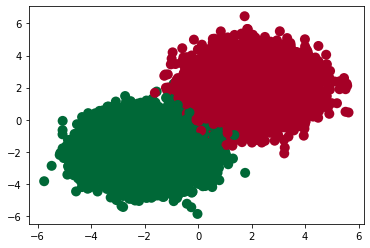

In [3]:
plt.scatter(features.data.numpy()[:, 0], features.data.numpy()[:, 1], c=labels.data.numpy(), s=100, lw=0, cmap='RdYlGn')
plt.show()

## 2 读取数据

In [4]:
batch_size = 64
train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_features, test_labels)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,  num_workers=0)

In [5]:
for X, y in train_iter:
    print(X, y)
    break

tensor([[ 1.7023,  1.6804,  1.0621,  ...,  2.1323,  2.2438,  2.1338],
        [ 2.4985, -1.3099,  1.6353,  ...,  1.8337,  2.2099,  3.2698],
        [-4.0448, -0.3097, -1.4958,  ..., -1.7323, -3.2007, -0.7927],
        ...,
        [-2.5434, -2.5159, -2.4724,  ..., -3.4238,  1.2710, -3.0849],
        [-5.4740, -2.8649, -1.0663,  ..., -1.8667, -1.1484, -2.1488],
        [-1.7369, -2.5921, -1.3068,  ..., -1.1253, -2.7680, -1.0124]]) tensor([[0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
      

## 3 定义模型

In [6]:
num_inputs, num_outputs, num_hiddens = 500, 1, 200

net = nn.Sequential(
    nn.Linear(num_inputs, num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens, num_outputs)
)

for params in net.parameters():
    init.normal_(params, mean=0, std=0.01)

## 4 定义损失函数

In [7]:
loss = torch.nn.BCEWithLogitsLoss()

## 5 定义优化算法

In [8]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.003)

## 6 精确度计算函数

In [9]:
def evaluate_accuracy(data_iter, net, loss):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        acc_sum += (net(X).ge(0).float() == y).sum()
        test_l_sum += loss(net(X), y).sum()
        n += y.shape[0]
    return acc_sum / n, test_l_sum / n

## 7 定义loss画图函数

In [10]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None, legend=None, figsize=(3.5, 2.5)):
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

## 8 训练模型

In [11]:
def train(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, optimizer=None):
    train_ls, test_ls = [], []
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            # 反向传播 + 更新优化参数
            l.backward()
            if optimizer == None:
                SGD(params, lr)
            else:
                optimizer.step()
        
        train_acc, train_l = evaluate_accuracy(train_iter, net, loss)
        test_acc, test_l = evaluate_accuracy(test_iter, net, loss)
        train_ls.append(train_l)
        test_ls.append(test_l)
        print('epoch %d, train loss %.4f, test_loss %.4f, train_acc %.3f, test_acc %.3f' % (epoch + 1, train_ls[-1], test_ls[-1], train_acc, test_acc))
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss', range(1, num_epochs + 1), test_ls, ['train', 'test'])
    return train_ls, test_ls

epoch 1, train loss 0.0006, test_loss 0.0006, train_acc 1.000, test_acc 1.000
epoch 2, train loss 0.0002, test_loss 0.0002, train_acc 1.000, test_acc 1.000
epoch 3, train loss 0.0001, test_loss 0.0001, train_acc 1.000, test_acc 1.000
epoch 4, train loss 0.0001, test_loss 0.0001, train_acc 1.000, test_acc 1.000
epoch 5, train loss 0.0001, test_loss 0.0001, train_acc 1.000, test_acc 1.000


([tensor(0.0006, grad_fn=<DivBackward0>),
  tensor(0.0002, grad_fn=<DivBackward0>),
  tensor(0.0001, grad_fn=<DivBackward0>),
  tensor(6.7991e-05, grad_fn=<DivBackward0>),
  tensor(5.0116e-05, grad_fn=<DivBackward0>)],
 [tensor(0.0006, grad_fn=<DivBackward0>),
  tensor(0.0002, grad_fn=<DivBackward0>),
  tensor(0.0001, grad_fn=<DivBackward0>),
  tensor(6.8102e-05, grad_fn=<DivBackward0>),
  tensor(5.0208e-05, grad_fn=<DivBackward0>)])

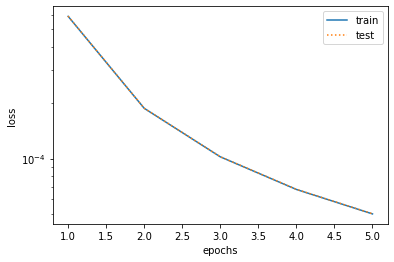

In [12]:
num_epochs = 5
lr = 0.003
train(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)